In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import io
import re
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from official import nlp
import official.nlp.optimization
from tensorflow import keras
from tensorflow.keras import layers
import import_ipynb
# from custom_matching_layers import *
from sklearn.model_selection import train_test_split
import json

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [4]:
print(os.listdir("./datasets"))
print(os.listdir("./datasets/MSRP"))

['MSRP', 'SICK', 'QQP']
['msrp_test.txt', 'msrp_train.txt', 'msrptrain.csv', 'msrp.csv', 'msrptest.csv', 'MSRParaphraseCorpus.msi']


In [5]:
df_qqp = pd.read_csv('./datasets/MSRP/msrp.csv')

In [6]:
df_qqp

,id,qid1,qid2,question1,question2,is_duplicate
0,0,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1
1,1,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0
2,2,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1
3,3,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0
4,4,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1
...,...,...,...,...,...,...
5796,5796,2685984,2686122,"After Hughes refused to rehire Hernandez , he ...",Hernandez filed an Equal Employment Opportunit...,0
5797,5797,339215,339172,There are 103 Democrats in the Assembly and 47...,Democrats dominate the Assembly while Republic...,0
5798,5798,2996850,2996734,Bethany Hamilton remained in stable condition ...,"Bethany , who remained in stable condition aft...",0
5799,5799,2095781,2095812,"Last week the power station ’ s US owners , AE...","The news comes after Drax 's American owner , ...",1


In [7]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))

def text_to_word_list(text, remove_stop_words=False):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()
    
    if remove_stop_words:
        text = [wd for wd in text if wd not in stops]

    return text

[nltk_data] Downloading package stopwords to /home/pranav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
text_to_word_list('step by step')

['step', 'by', 'step']

In [9]:
df_qqp['question1'] = df_qqp['question1'].map(lambda x: text_to_word_list(x))
df_qqp['question2'] = df_qqp['question2'].map(lambda x: text_to_word_list(x))
df_qqp['len_q1'] = df_qqp['question1'].map(lambda x: len(x))
df_qqp['len_q2'] = df_qqp['question2'].map(lambda x: len(x))

In [10]:
df_qqp.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2
0,0,702876,702977,"[amrozi, accused, his, brother, whom, he, call...","[referring, to, him, as, only, the, witness, a...",1,14,16
1,1,2108705,2108831,"[yucaipa, owned, dominick, before, selling, th...","[yucaipa, bought, dominick, in, 1995, for, 693...",0,15,19
2,2,1330381,1330521,"[they, had, published, an, advertisement, on, ...","[on, june, 10, the, ship, owners, had, publish...",1,18,18
3,3,3344667,3344648,"[around, 0335, gmt, tab, shares, were, up, 19,...","[tab, shares, jumped, 20, cents, or, 4, 6, to,...",0,26,18
4,4,1236820,1236712,"[the, stock, rose, 2, 11, or, about, 11, perce...","[pg, e, corp, shares, jumped, 1, 63, or, 8, pe...",1,21,21


In [11]:
df_qqp.describe()

,id,qid1,qid2,is_duplicate,len_q1,len_q2
count,5801.000000,5.801000e+03,5.801000e+03,5801.000000,5801.000000,5801.000000
mean,2900.000000,1.684367e+06,1.684367e+06,0.672298,19.889502,19.839683
std,1674.748787,9.916988e+05,9.917017e+05,0.469416,5.457898,5.471728
min,0.000000,2.670000e+02,1.400000e+02,0.000000,6.000000,5.000000
25%,1450.000000,8.068650e+05,8.068650e+05,0.000000,16.000000,16.000000
50%,2900.000000,1.691429e+06,1.691465e+06,1.000000,20.000000,20.000000
75%,4350.000000,2.537987e+06,2.538021e+06,1.000000,24.000000,24.000000
max,5800.000000,3.464314e+06,3.464302e+06,1.000000,39.000000,39.000000


In [12]:
sentence_len = 40
max_sentence_length = sentence_len
embeddings_len = 300
max_unique_words = 20000

In [13]:
temp = df_qqp[(df_qqp['len_q1']<sentence_len) & (df_qqp['len_q2']<sentence_len)]
temp

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2
0,0,702876,702977,"[amrozi, accused, his, brother, whom, he, call...","[referring, to, him, as, only, the, witness, a...",1,14,16
1,1,2108705,2108831,"[yucaipa, owned, dominick, before, selling, th...","[yucaipa, bought, dominick, in, 1995, for, 693...",0,15,19
2,2,1330381,1330521,"[they, had, published, an, advertisement, on, ...","[on, june, 10, the, ship, owners, had, publish...",1,18,18
3,3,3344667,3344648,"[around, 0335, gmt, tab, shares, were, up, 19,...","[tab, shares, jumped, 20, cents, or, 4, 6, to,...",0,26,18
4,4,1236820,1236712,"[the, stock, rose, 2, 11, or, about, 11, perce...","[pg, e, corp, shares, jumped, 1, 63, or, 8, pe...",1,21,21
...,...,...,...,...,...,...,...,...
5796,5796,2685984,2686122,"[after, hughes, refused, to, rehire, hernandez...","[hernandez, filed, an, equal, employment, oppo...",0,14,10
5797,5797,339215,339172,"[there, are, 103, democrats, in, the, assembly...","[democrats, dominate, the, assembly, while, re...",0,10,9
5798,5798,2996850,2996734,"[bethany, hamilton, remained, in, stable, cond...","[bethany, who, remained, in, stable, condition...",0,12,16
5799,5799,2095781,2095812,"[last, week, the, power, station, s, us, owner...","[the, news, comes, after, drax, american, owne...",1,26,28


In [14]:
all_questions = list(temp['question1'].values) + list(temp['question2'].values)

In [15]:
# glove_embeddings = {}
# with open('8/model.txt') as f:
#     for line in f:
#         word, coefs = line.split(maxsplit=1)
#         coefs = np.fromstring(coefs, "f", sep=" ")
#         glove_embeddings[word.lower()] = coefs

# print("Found %s word vectors." % len(glove_embeddings))

glove_embeddings = {}
with open('glove.6B/glove.6B.300d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word.lower()] = coefs

print("Found %s word vectors." % len(glove_embeddings))

Found 400000 word vectors.


In [16]:
len(glove_embeddings.keys())

400000

In [17]:
word_to_index = dict()
index_to_word = ['<pad>','unk']
word_to_index['unk'] = 1
questions_cols = ['question1', 'question2']
q1_indexes = []
q2_indexes = []
hits = 0
misses = 0
for index, row in tqdm(temp.iterrows()):
    for question in questions_cols:
        q2n = []
        for word in row[question]:
            if word not in glove_embeddings:
                misses+=1
                word = 'unk'
            else:
                hits+=1
            if word not in word_to_index:
                word_to_index[word] = len(index_to_word)
                q2n.append(len(index_to_word))
                index_to_word.append(word)
            else:
                q2n.append(word_to_index[word])
        if question == 'question1':
            q1_indexes.append(q2n)
        else:
            q2_indexes.append(q2n)
print(hits,misses)
temp['q1_indexes'] = q1_indexes
temp['q2_indexes'] = q2_indexes

5801it [00:00, 9606.21it/s]

229616 853


In [18]:
temp

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,q1_indexes,q2_indexes
0,0,702876,702977,"[amrozi, accused, his, brother, whom, he, call...","[referring, to, him, as, only, the, witness, a...",1,14,16,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 4, 14]","[15, 16, 17, 18, 19, 9, 10, 2, 3, 4, 5, 11, 12..."
1,1,2108705,2108831,"[yucaipa, owned, dominick, before, selling, th...","[yucaipa, bought, dominick, in, 1995, for, 693...",0,15,19,"[20, 21, 22, 23, 24, 9, 25, 16, 26, 27, 28, 29...","[20, 33, 22, 27, 34, 29, 35, 36, 37, 38, 39, 1..."
2,2,1330381,1330521,"[they, had, published, an, advertisement, on, ...","[on, june, 10, the, ship, owners, had, publish...",1,18,18,"[42, 43, 44, 45, 46, 47, 9, 48, 47, 49, 50, 51...","[47, 49, 50, 9, 55, 56, 43, 44, 45, 46, 47, 9,..."
3,3,3344667,3344648,"[around, 0335, gmt, tab, shares, were, up, 19,...","[tab, shares, jumped, 20, cents, or, 4, 6, to,...",0,26,18,"[58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 6...","[61, 62, 78, 79, 66, 67, 68, 80, 16, 74, 70, 7..."
4,4,1236820,1236712,"[the, stock, rose, 2, 11, or, about, 11, perce...","[pg, e, corp, shares, jumped, 1, 63, or, 8, pe...",1,21,21,"[9, 82, 83, 30, 84, 67, 85, 84, 86, 16, 87, 88...","[94, 95, 96, 62, 78, 40, 97, 67, 41, 86, 16, 8..."
...,...,...,...,...,...,...,...,...,...,...
5796,5796,2685984,2686122,"[after, hughes, refused, to, rehire, hernandez...","[hernandez, filed, an, equal, employment, oppo...",0,14,10,"[466, 1753, 2131, 16, 10496, 2372, 7, 15176, 1...","[2372, 574, 45, 1830, 5262, 2175, 653, 4930, 3..."
5797,5797,339215,339172,"[there, are, 103, democrats, in, the, assembly...","[democrats, dominate, the, assembly, while, re...",0,10,9,"[559, 487, 3822, 1864, 27, 9, 4849, 37, 1352, ...","[1864, 15177, 9, 4849, 181, 1863, 1665, 9, 3000]"
5798,5798,2996850,2996734,"[bethany, hamilton, remained, in, stable, cond...","[bethany, who, remained, in, stable, condition...",0,12,16,"[10364, 1062, 2337, 27, 1735, 2316, 1780, 466,...","[10364, 611, 2337, 27, 1735, 2316, 466, 9, 125..."
5799,5799,2095781,2095812,"[last, week, the, power, station, s, us, owner...","[the, news, comes, after, drax, american, owne...",1,26,28,"[505, 976, 9, 985, 473, 139, 632, 56, 9596, 96...","[9, 685, 853, 466, 7137, 488, 9595, 9596, 96, ..."


In [19]:
len(word_to_index)

15177

In [20]:
num_tokens = len(word_to_index) + 2
embedding_matrix = np.zeros((num_tokens, embeddings_len))
for word, i in word_to_index.items():
    embedding_matrix[i] = glove_embeddings[word]

In [21]:
# temp = temp[temp['q1_indexes'].map(lambda x:len(x))<max_sentence_length]
# temp = temp[temp['q2_indexes'].map(lambda x:len(x))<max_sentence_length]
temp.loc[:,'l'] = pd.Series(list(keras.preprocessing.sequence.pad_sequences(temp['q1_indexes'], maxlen=max_sentence_length)),index=temp.index)
temp.loc[:,'r'] = pd.Series(list(keras.preprocessing.sequence.pad_sequences(temp['q2_indexes'], maxlen=max_sentence_length)),index=temp.index)

In [22]:
temp

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,q1_indexes,q2_indexes,l,r
0,0,702876,702977,"[amrozi, accused, his, brother, whom, he, call...","[referring, to, him, as, only, the, witness, a...",1,14,16,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 4, 14]","[15, 16, 17, 18, 19, 9, 10, 2, 3, 4, 5, 11, 12...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,2108705,2108831,"[yucaipa, owned, dominick, before, selling, th...","[yucaipa, bought, dominick, in, 1995, for, 693...",0,15,19,"[20, 21, 22, 23, 24, 9, 25, 16, 26, 27, 28, 29...","[20, 33, 22, 27, 34, 29, 35, 36, 37, 38, 39, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,1330381,1330521,"[they, had, published, an, advertisement, on, ...","[on, june, 10, the, ship, owners, had, publish...",1,18,18,"[42, 43, 44, 45, 46, 47, 9, 48, 47, 49, 50, 51...","[47, 49, 50, 9, 55, 56, 43, 44, 45, 46, 47, 9,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,3344667,3344648,"[around, 0335, gmt, tab, shares, were, up, 19,...","[tab, shares, jumped, 20, cents, or, 4, 6, to,...",0,26,18,"[58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 6...","[61, 62, 78, 79, 66, 67, 68, 80, 16, 74, 70, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 58,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,1236820,1236712,"[the, stock, rose, 2, 11, or, about, 11, perce...","[pg, e, corp, shares, jumped, 1, 63, or, 8, pe...",1,21,21,"[9, 82, 83, 30, 84, 67, 85, 84, 86, 16, 87, 88...","[94, 95, 96, 62, 78, 40, 97, 67, 41, 86, 16, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
5796,5796,2685984,2686122,"[after, hughes, refused, to, rehire, hernandez...","[hernandez, filed, an, equal, employment, oppo...",0,14,10,"[466, 1753, 2131, 16, 10496, 2372, 7, 15176, 1...","[2372, 574, 45, 1830, 5262, 2175, 653, 4930, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5797,5797,339215,339172,"[there, are, 103, democrats, in, the, assembly...","[democrats, dominate, the, assembly, while, re...",0,10,9,"[559, 487, 3822, 1864, 27, 9, 4849, 37, 1352, ...","[1864, 15177, 9, 4849, 181, 1863, 1665, 9, 3000]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5798,5798,2996850,2996734,"[bethany, hamilton, remained, in, stable, cond...","[bethany, who, remained, in, stable, condition...",0,12,16,"[10364, 1062, 2337, 27, 1735, 2316, 1780, 466,...","[10364, 611, 2337, 27, 1735, 2316, 466, 9, 125...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5799,5799,2095781,2095812,"[last, week, the, power, station, s, us, owner...","[the, news, comes, after, drax, american, owne...",1,26,28,"[505, 976, 9, 985, 473, 139, 632, 56, 9596, 96...","[9, 685, 853, 466, 7137, 488, 9595, 9596, 96, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 505...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 685, 8..."


In [23]:
X_l = np.stack(temp['l'].to_numpy(),axis=1).T
X_r = np.stack(temp['r'].to_numpy(),axis=1).T
X = np.stack([X_l,X_r],axis=1)
# X = np.stack(temp['l'].to_numpy(),axis=1).T
Y = np.stack(temp['is_duplicate'].to_numpy())
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

In [24]:
temp.iloc[0]

id                                                              0
qid1                                                       702876
qid2                                                       702977
question1       [amrozi, accused, his, brother, whom, he, call...
question2       [referring, to, him, as, only, the, witness, a...
is_duplicate                                                    1
len_q1                                                         14
len_q2                                                         16
q1_indexes        [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 4, 14]
q2_indexes      [15, 16, 17, 18, 19, 9, 10, 2, 3, 4, 5, 11, 12...
l               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
r               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 0, dtype: object

In [25]:
temp.iloc[0]['l']

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13,  4, 14], dtype=int32)

In [26]:
embedding_matrix[1]

array([ 3.00709993e-01, -4.68670011e-01, -2.06169993e-01, -8.09780002e-01,
       -2.38890007e-01,  2.43290007e-01,  1.65379997e-02, -3.56869996e-02,
       -2.23059997e-01,  9.51889992e-01, -3.22730005e-01,  2.19799995e-01,
       -6.75240010e-02, -3.72200012e-01, -3.97179991e-01, -4.38609987e-01,
        1.19670004e-01, -2.99640000e-01,  2.84369998e-02, -8.75440016e-02,
        1.65690005e-01, -4.94509995e-01, -6.20109975e-01, -1.65739998e-01,
       -9.72179994e-02, -9.94739980e-02, -8.03069994e-02, -3.93379986e-01,
       -2.41950005e-01,  3.20230007e-01, -5.33200026e-01, -4.01840001e-01,
       -6.71350002e-01, -7.85610005e-02,  5.55459976e-01,  2.99970001e-01,
       -9.96500030e-02, -6.70350015e-01,  1.26690000e-01, -1.86179996e-01,
       -6.26209974e-02,  4.52899992e-01,  3.92650008e-01,  2.41209999e-01,
       -4.14739996e-01, -6.18900001e-01, -1.04120001e-01, -3.10429990e-01,
       -6.67880010e-03, -8.32480013e-01,  6.51499987e-01,  9.01809990e-01,
        2.41459999e-02, -

In [27]:
embedding_matrix.shape

(15179, 300)

## Building Model

In [92]:
embedding_layer = layers.Embedding(
    num_tokens,
    embeddings_len,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [93]:
left_input = layers.Input(shape=(max_sentence_length,), dtype='int32')
right_input = layers.Input(shape=(max_sentence_length,), dtype='int32')

In [94]:
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

In [95]:
lstm_dim = 64
forward_layer = layers.LSTM(lstm_dim, return_sequences=True, return_state=True, dropout=0.1)
backward_layer = layers.LSTM(lstm_dim, return_sequences=True, return_state=True, go_backwards=True, dropout=0.1)

In [96]:
forward_left, forward_left_final, _ = forward_layer(encoded_left)
forward_right, forward_right_final, _ = forward_layer(encoded_right)
backward_left, backward_left_final, _ = backward_layer(encoded_left)
backward_left = keras.backend.reverse(backward_left,axes=-2)
backward_right, backward_right_final, _ = backward_layer(encoded_right)
backward_right = keras.backend.reverse(backward_right,axes=-2)

In [97]:
perspectives = 20

In [98]:
class matching_1(layers.Layer):
    def __init__(self, units=perspectives):
        super(matching_1, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(self.units,input_shape[0][-1]),
            initializer="random_normal",
            trainable=True,
        )

    @tf.function
    def call(self, inputs, **kwargs):
        left = tf.expand_dims(inputs[0], axis=-2) # b,s,1,d
        left = tf.math.multiply(self.w,left) # b,s,p,d
        right = tf.expand_dims(inputs[1], axis=-2) # b,1,d
        right = tf.math.multiply(self.w,right) # b,p,d
        matching = layers.Dot(axes=(3, 2),normalize=True)([left,right]) #b,s,p,p
        matching = tf.linalg.diag_part(matching) #b,s,p
        return matching

In [99]:
class matching_2(layers.Layer):
    def __init__(self, units=perspectives):
        super(matching_2, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(self.units,input_shape[0][-1]),
            initializer="random_normal",
            trainable=True,
        )

    @tf.function
    def call(self, inputs, **kwargs):
        left = tf.expand_dims(inputs[0], axis=-2) # b,s,1,d
        left = tf.math.multiply(self.w,left) # b,s,p,d
        right = tf.expand_dims(inputs[1], axis=-2) # b,s,1,d
        right = tf.math.multiply(self.w,right) # b,s,p,d
        matching = layers.Dot(axes=(3, 3),normalize=True)([left,right]) #b,s,p,s,p
        matching = tf.reduce_max(matching,axis=3)
        matching = tf.linalg.diag_part(matching) #b,s,p
        return matching

In [100]:
class matching_3(layers.Layer):
    def __init__(self, units=perspectives):
        super(matching_3, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(self.units,input_shape[0][-1]),
            initializer="random_normal",
            trainable=True,
        )
        self.sentence_length = input_shape[0][1]

    @tf.function
    def call(self, inputs, **kwargs):      
        aij = layers.Dot(axes=(2,2),normalize=True)([inputs[0],inputs[1]]) # b,s,s
        weighted_right = tf.einsum('bsk,bkd->bsd', aij, inputs[1]) # b,s,d
        normal = tf.reduce_sum(aij,2,keepdims=True) # b,s,1
        right = weighted_right/normal # b,s,d
        
        left = tf.expand_dims(inputs[0], axis=-2) # b,s,1,d
        left = tf.math.multiply(self.w,left) # b,s,p,d
        right = tf.expand_dims(right, axis=-2) # b,s,1,d
        right = tf.math.multiply(self.w,right) # b,s,p,d
        
        matching = []
        for sentence in range(self.sentence_length):
            left_sentence = left[:,sentence,:,:] #b,p,d
            right_mean = right[:,sentence,:,:] #b,p,d
            match = layers.Dot(axes=(2, 2),normalize=True)([left_sentence,right_mean]) #b,p,p
            match = tf.linalg.diag_part(match)
            matching.append(match)
        matching = tf.stack(matching,axis=1)
        return matching

In [101]:
class matching_4(layers.Layer):
    def __init__(self, units=perspectives):
        super(matching_4, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(self.units,input_shape[0][-1]),
            initializer="random_normal",
            trainable=True,
        )
        self.sentence_length = input_shape[0][1]

    @tf.function
    def call(self, inputs, **kwargs):
        
        aij = layers.Dot(axes=(2,2),normalize=True)([inputs[0],inputs[1]]) # b,s,s
        argmax_aij = tf.math.argmax(aij,2) # b,s
        right = tf.gather(inputs[1],argmax_aij,axis=1,batch_dims=1) # b,s,d
        
        left = tf.expand_dims(inputs[0], axis=-2) # b,s,1,d
        left = tf.math.multiply(self.w,left) # b,s,p,d
        right = tf.expand_dims(right, axis=-2) # b,s,1,d
        right = tf.math.multiply(self.w,right) # b,s,p,d
        
        matching = []
        for sentence in range(self.sentence_length):
            left_sentence = left[:,sentence,:,:] #b,p,d
            right_mean = right[:,sentence,:,:] #b,p,d
            match = layers.Dot(axes=(2, 2),normalize=True)([left_sentence,right_mean]) #b,p,p
            match = tf.linalg.diag_part(match)
            matching.append(match)
        matching = tf.stack(matching,axis=1)
        return matching

In [102]:
forward_matching_1 = matching_1()
backward_matching_1 = matching_1()

match_1_forward_pq = forward_matching_1([forward_left,forward_right_final])
match_1_forward_qp = forward_matching_1([forward_right,forward_left_final])
match_1_backward_pq = backward_matching_1([backward_left,backward_right_final])
match_1_backward_qp = backward_matching_1([backward_right,backward_left_final])
match_1_pq = layers.Concatenate(axis=2)([match_1_forward_pq,match_1_backward_pq])
match_1_qp = layers.Concatenate(axis=2)([match_1_forward_qp,match_1_backward_qp])

forward_matching_2 = matching_2()
backward_matching_2 = matching_2()
match_2_forward_pq = forward_matching_2([forward_left,forward_right])
match_2_forward_qp = forward_matching_2([forward_right,forward_left])
match_2_backward_pq = backward_matching_2([backward_left,backward_right])
match_2_backward_qp = backward_matching_2([backward_right,backward_left])
match_2_pq = layers.Concatenate(axis=2)([match_2_forward_pq,match_2_backward_pq])
match_2_qp = layers.Concatenate(axis=2)([match_2_forward_qp,match_2_backward_qp])

forward_matching_3 = matching_3()
backward_matching_3 = matching_3()
match_3_forward_pq = forward_matching_3([forward_left,forward_right])
match_3_forward_qp = forward_matching_3([forward_right,forward_left])
match_3_backward_pq = backward_matching_3([backward_left,backward_right])
match_3_backward_qp = backward_matching_3([backward_right,backward_left])
match_3_pq = layers.Concatenate(axis=2)([match_3_forward_pq,match_3_backward_pq])
match_3_qp = layers.Concatenate(axis=2)([match_3_forward_qp,match_3_backward_qp])

forward_matching_4 = matching_4()
backward_matching_4 = matching_4()
match_4_forward_pq = forward_matching_4([forward_left,forward_right])
match_4_forward_qp = forward_matching_4([forward_right,forward_left])
match_4_backward_pq = backward_matching_4([backward_left,backward_right])
match_4_backward_qp = backward_matching_4([backward_right,backward_left])
match_4_pq = layers.Concatenate(axis=2)([match_4_forward_pq,match_4_backward_pq])
match_4_qp = layers.Concatenate(axis=2)([match_4_forward_qp,match_4_backward_qp])

In [103]:
# all_matching_p = layers.Concatenate(axis=2)([match_1_pq,match_2_pq,match_3_pq,match_4_pq])
all_matching_p = layers.Concatenate(axis=2)([match_1_pq,match_2_pq,match_4_pq])
# all_matching_q = layers.Concatenate(axis=2)([match_1_qp,match_2_qp,match_3_qp,match_4_qp])
all_matching_q = layers.Concatenate(axis=2)([match_1_qp,match_2_qp,match_4_qp])
aggregate = layers.Bidirectional(layers.LSTM(64,dropout=0.1))
# aggregate_p = aggregate(all_matching_p)
aggregate_p = aggregate(all_matching_p)
aggregate_q = aggregate(all_matching_q)
# aggregate_q = aggregate(all_matching_q)
concated = layers.Concatenate(axis=1)([aggregate_p,aggregate_q])
x = layers.Dense(128,activation='relu')(concated)
x = layers.Dropout(.1)(x)
x = layers.Dense(64,activation='relu')(x)
x = layers.Dropout(.1)(x)
# x = layers.Dense(64,activation='relu')(x)
final_output = layers.Dense(2,activation="softmax")(x)

In [104]:
model = keras.Model(inputs=[left_input,right_input], outputs=final_output
                    , name="BiMPM_model")
model.summary()

Model: "BiMPM_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 40, 300)      4553700     input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lstm_13 (LSTM)                  [(None, 40, 64), (No 93440       embedding_4[0][0]      

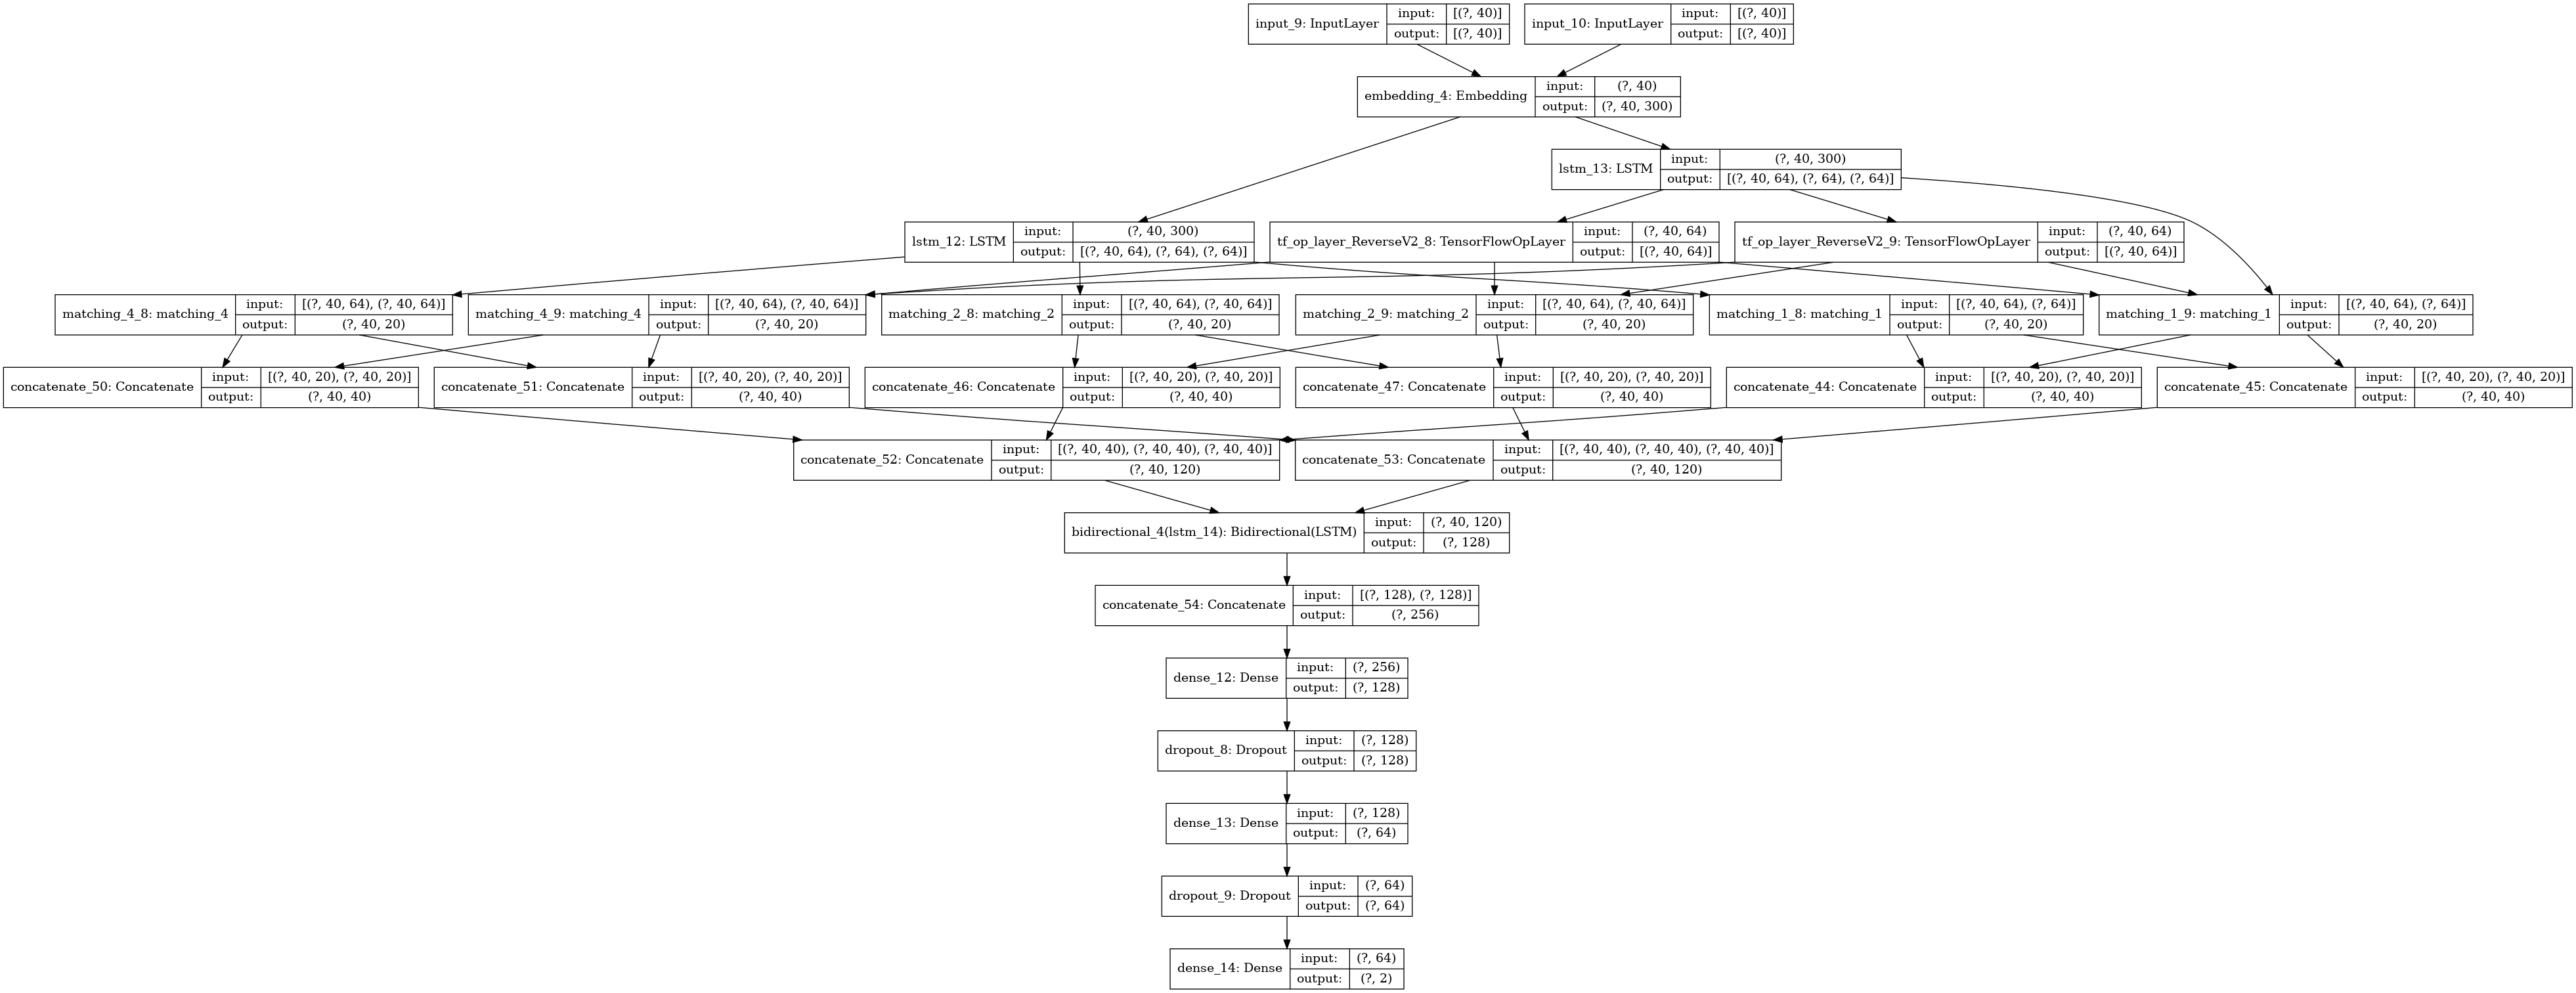

In [105]:
keras.utils.plot_model(model, "BiMPM.png", show_shapes=True)

In [106]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(
    optimizer='adam',
    loss=loss,
    metrics=metrics)

In [107]:
# model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [108]:
hist = model.fit([X_train[:,0], X_train[:,1]], Y_train, batch_size=16, epochs=3,
                            validation_data=([X_validation[:,0], X_validation[:,1]], Y_validation))

Epoch 1/3
290/290 [==============================] - 32s 109ms/step - loss: 0.6198 - accuracy: 0.6821 - val_loss: 0.6077 - val_accuracy: 0.6804
Epoch 2/3
290/290 [==============================] - 28s 95ms/step - loss: 0.5726 - accuracy: 0.7147 - val_loss: 0.5915 - val_accuracy: 0.7106
Epoch 3/3
290/290 [==============================] - 27s 94ms/step - loss: 0.5229 - accuracy: 0.7554 - val_loss: 0.5751 - val_accuracy: 0.7252


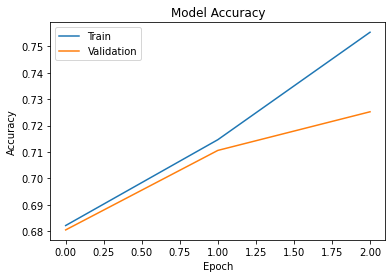

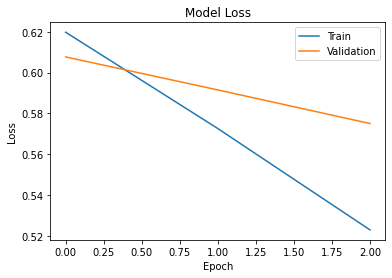

In [109]:
# Plot accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [110]:
model.save_weights("results/BiMPM_msrp",save_format="h5")

In [111]:
with open('results/BiMPM_msrp.json', 'w') as f:
    json.dump(hist.history, f)